# 9. GAN

GAN, loss 조정, LSGAN

In [ ]:
# Pytorch GAN examples for sin signal generation from noise
# https://www.kaggle.com/code/salmaneunus/a-tutorial-to-start-your-first-gan-journey

import torch
from torch import nn
import numpy as np
import math
import random
!pip install matplotlib
import matplotlib.pyplot as plt

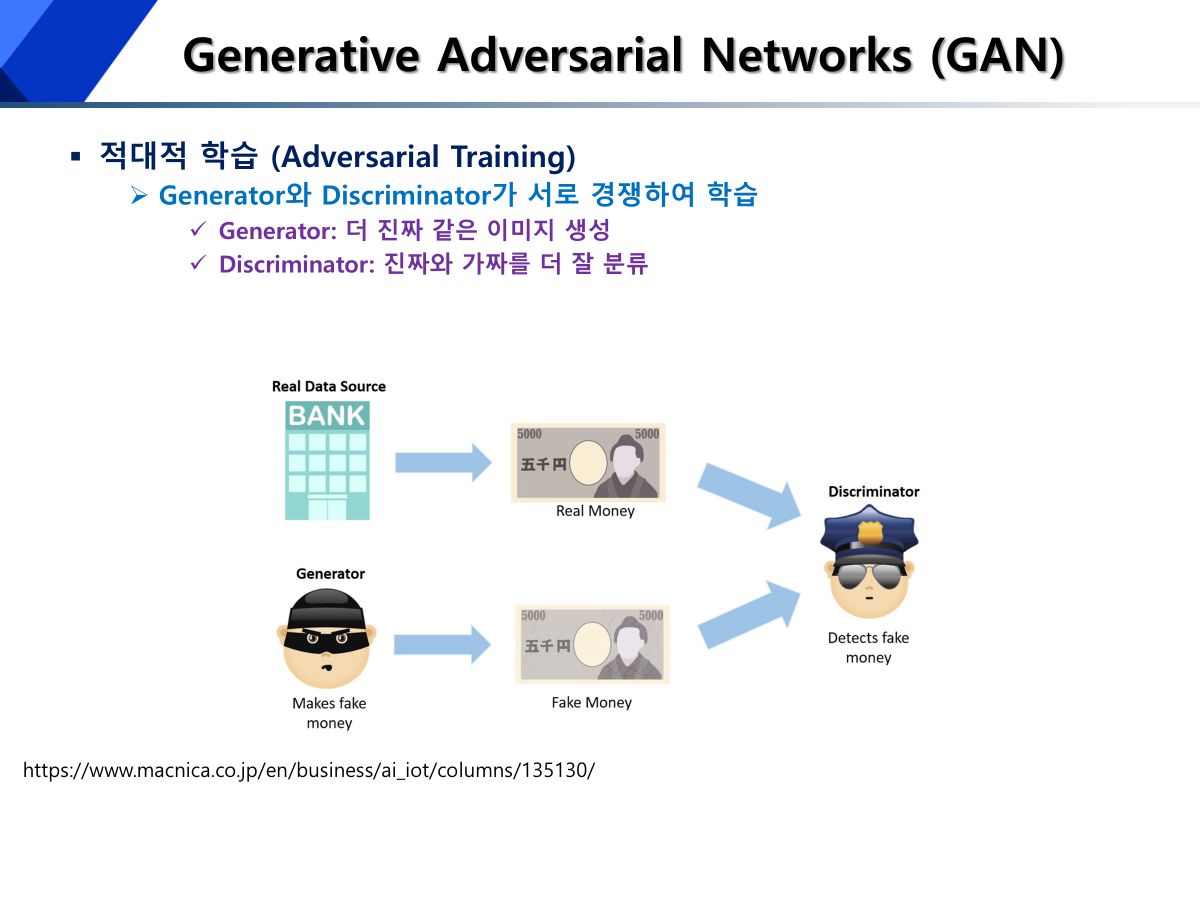
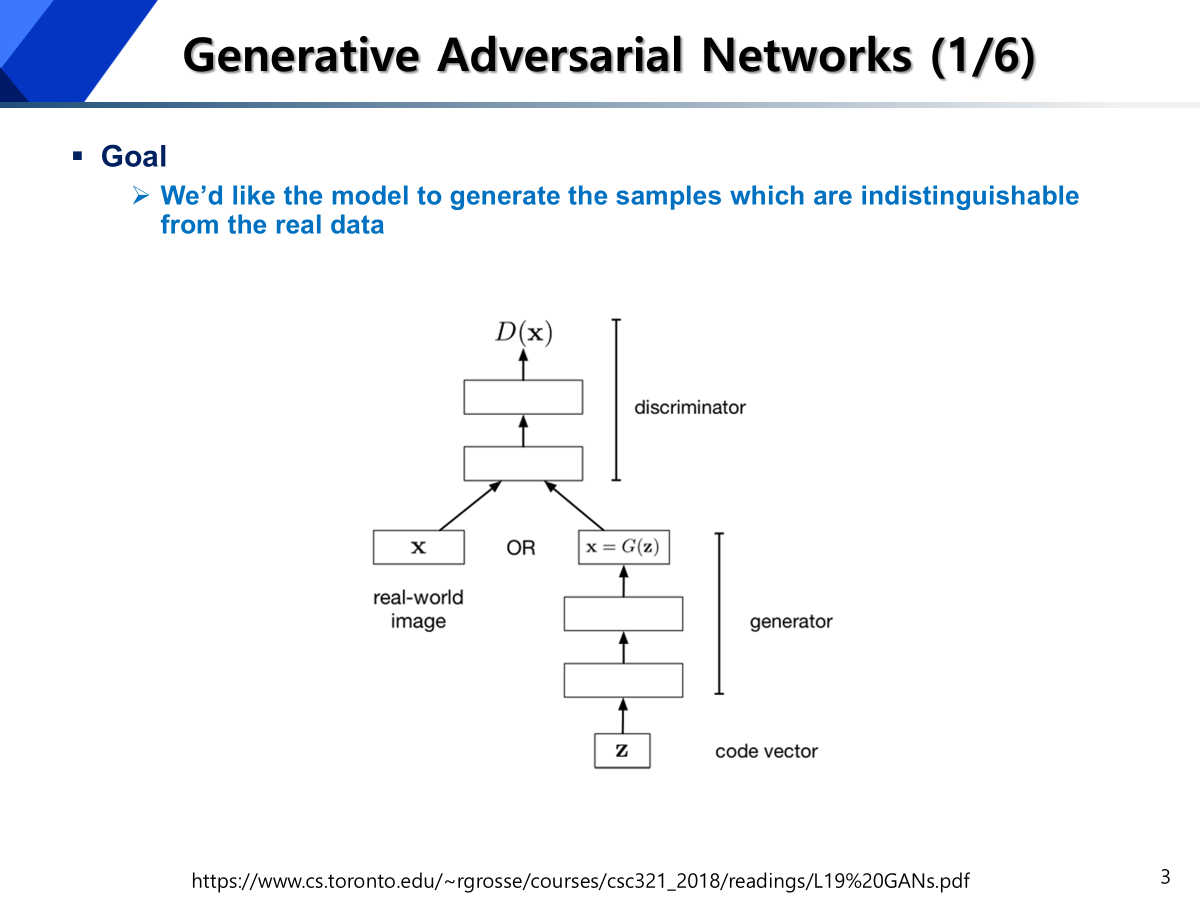
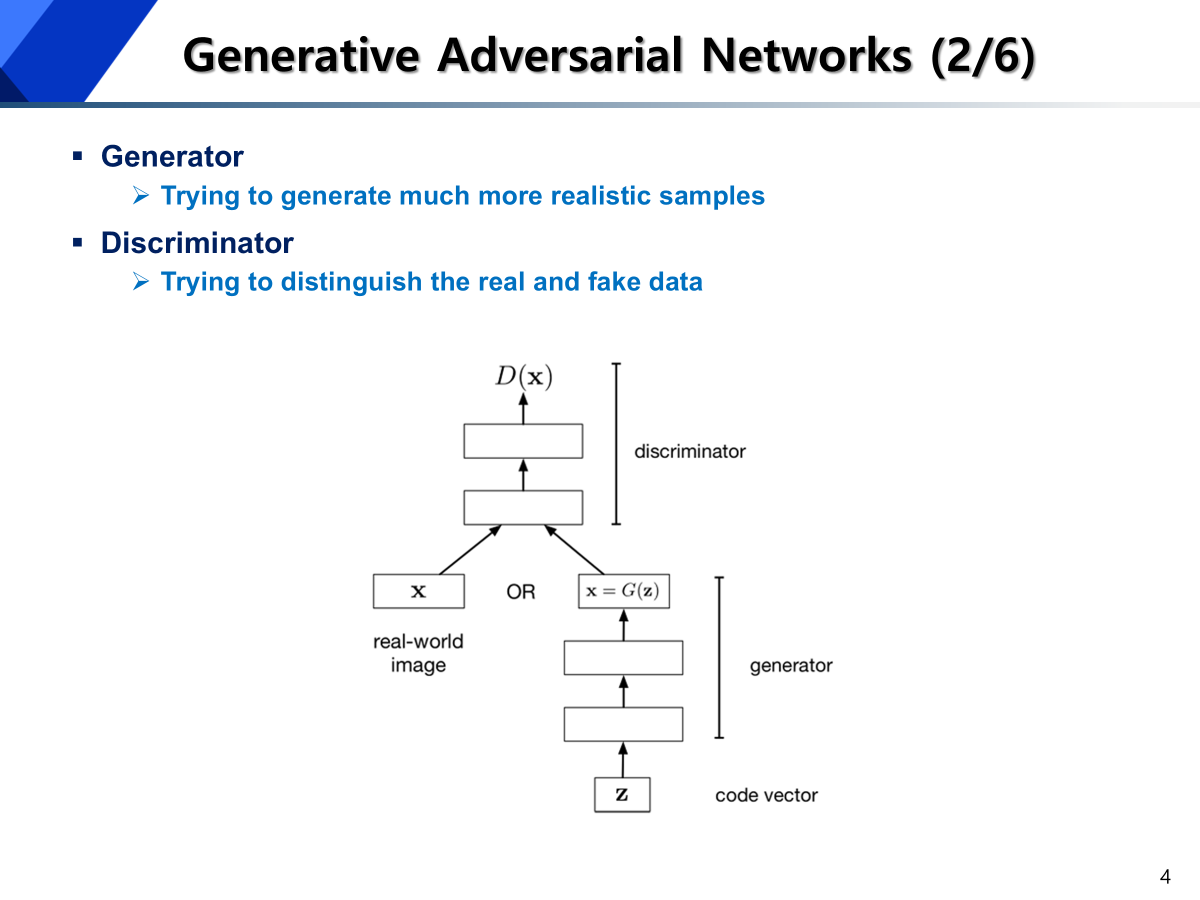
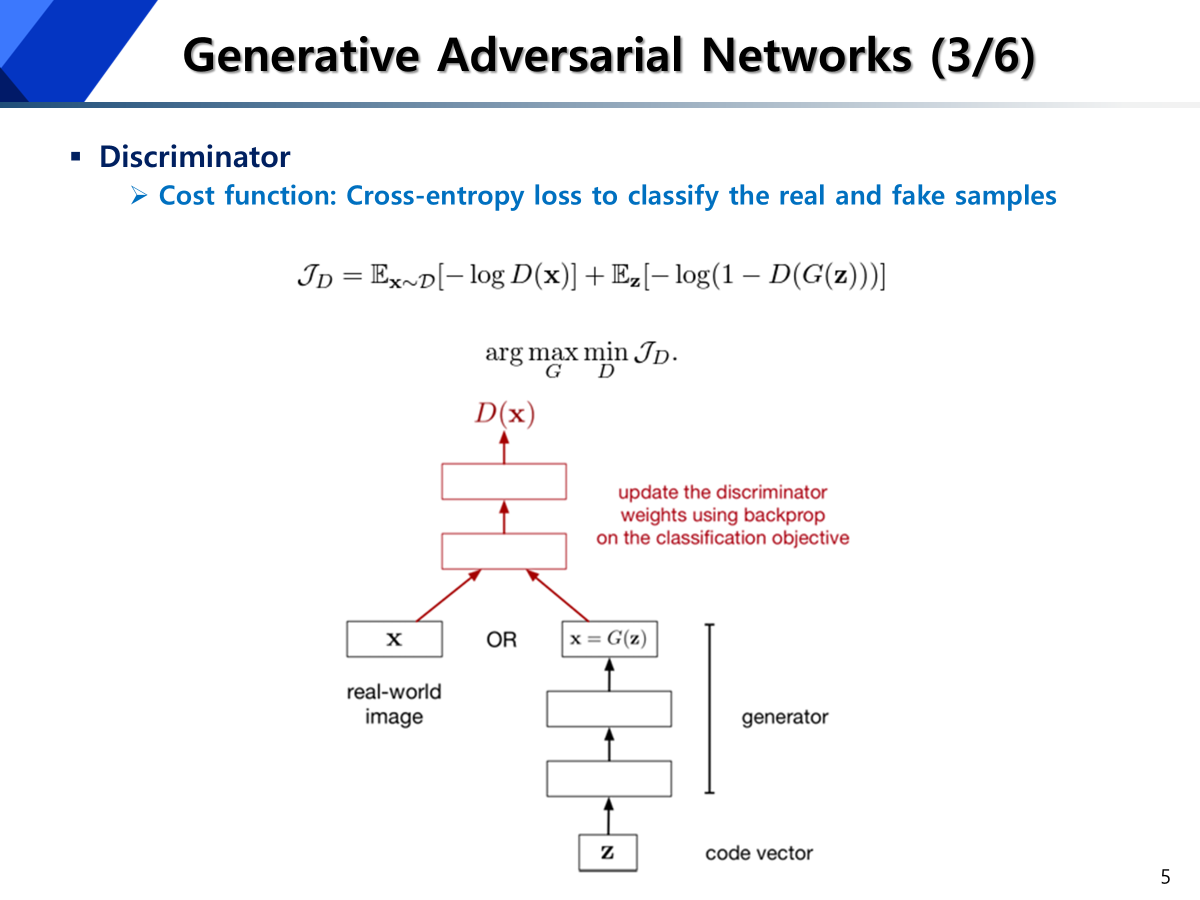
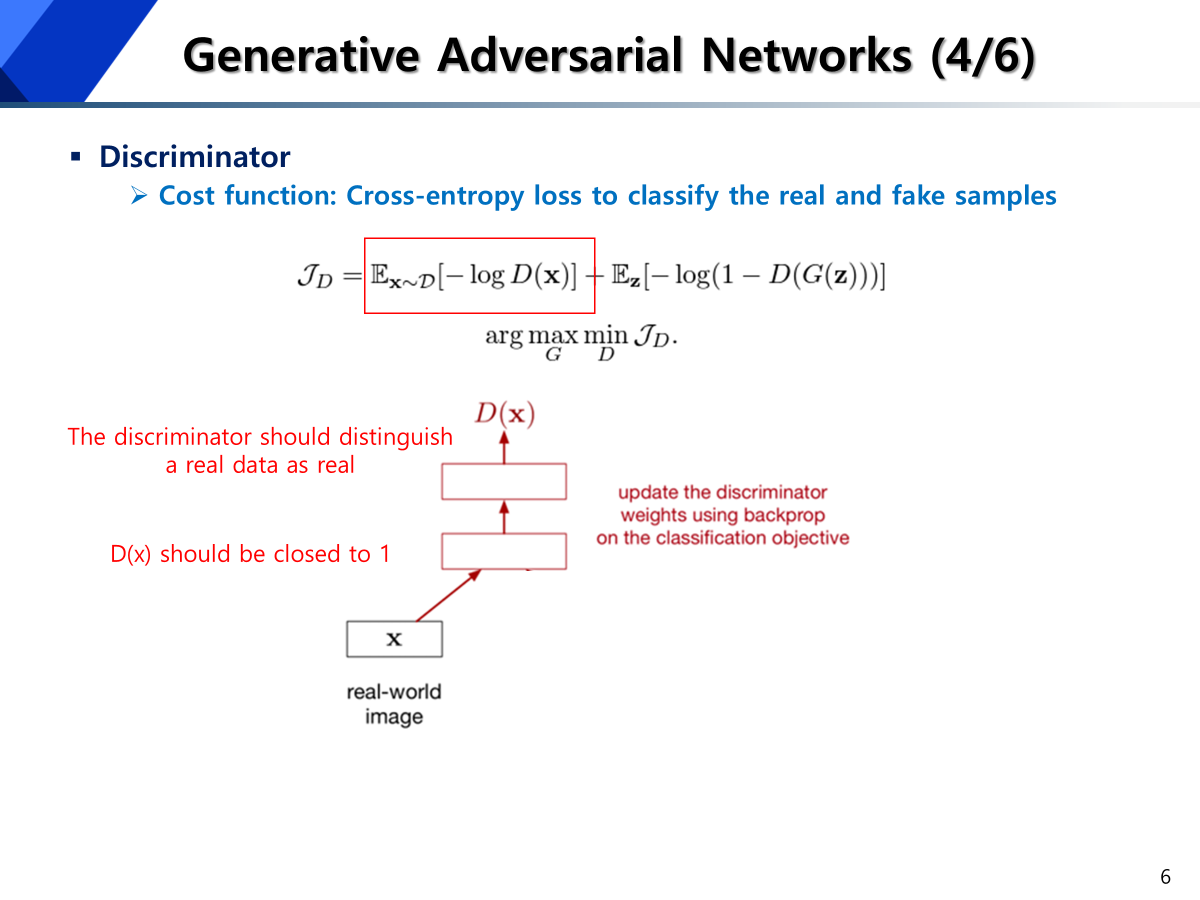
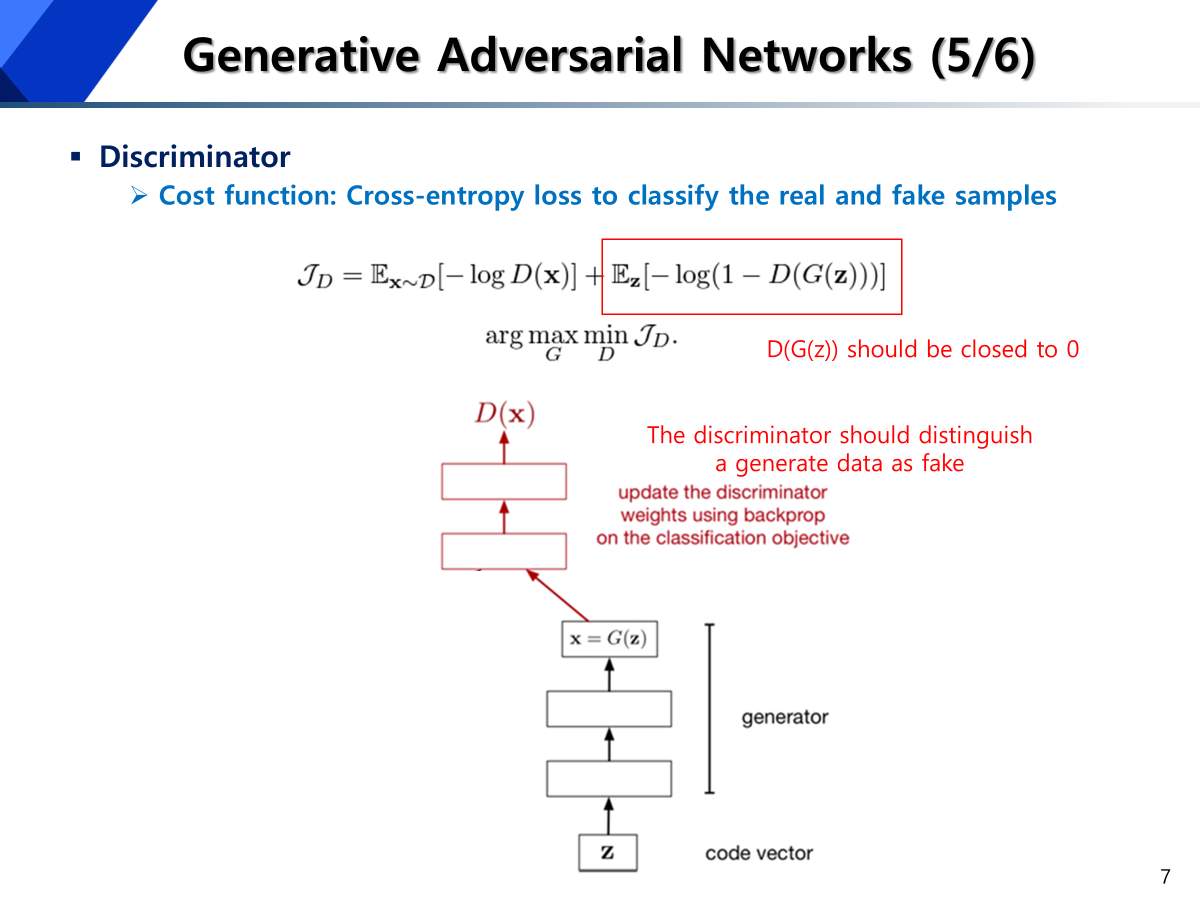
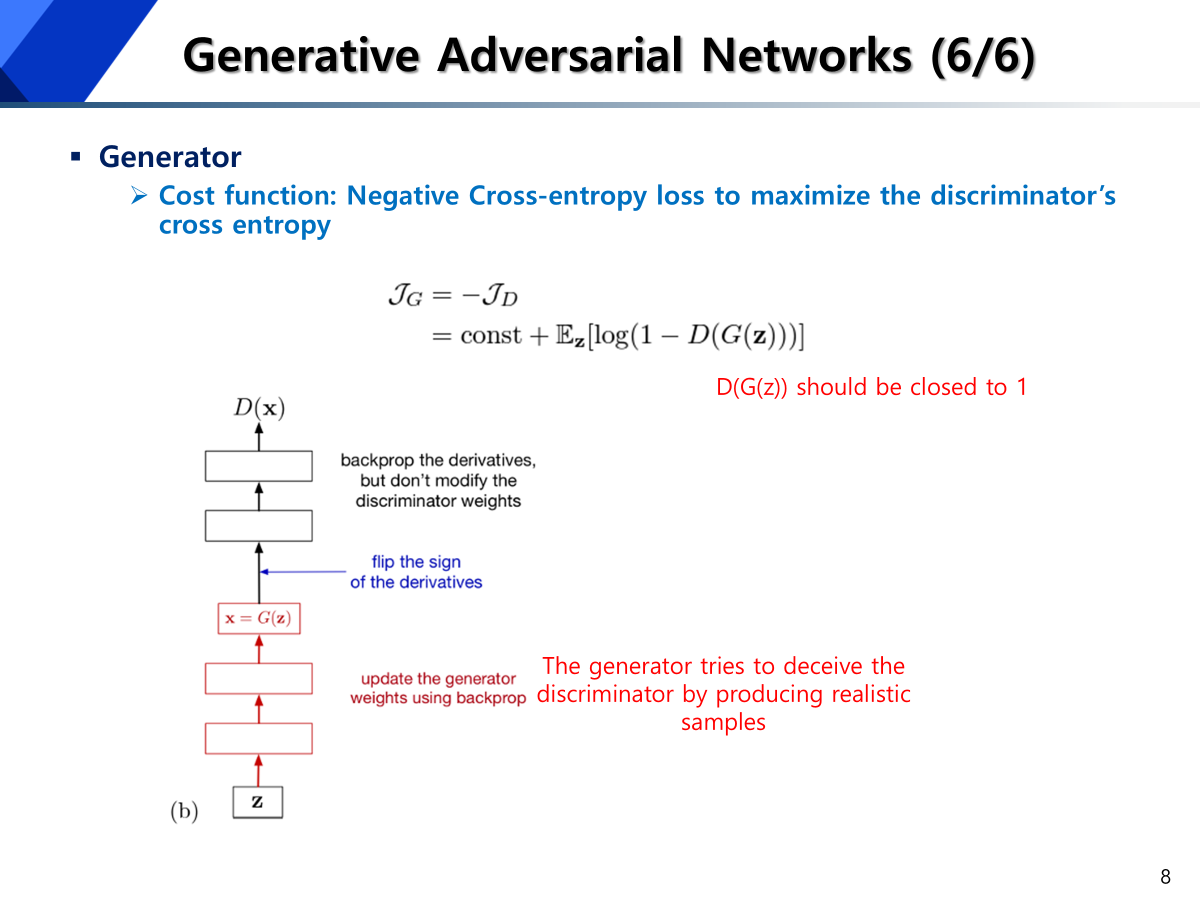

## Let's start working with your first GAN

Random generator seed ensures that the experiment can be replicated in any macine. The number 111 represents the random seed used to initialize the random number generator which is later used to initialize neural network's weights.

In [ ]:
torch.manual_seed(111)

In [ ]:
seed=1111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


### Preparing the training data

In [ ]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) # Input
train_data[:, 1] = torch.sin(train_data[:, 0]) # Target

train_labels = torch.zeros(train_data_length)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

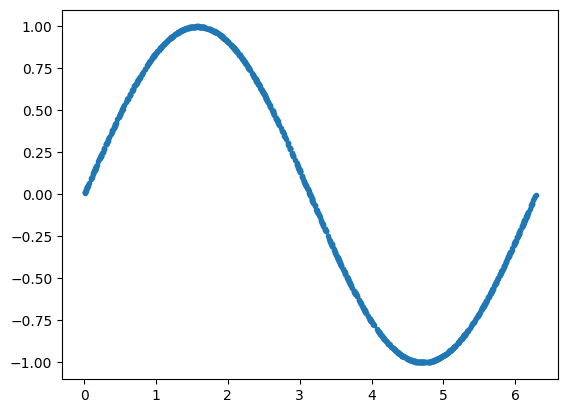

In [ ]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

### Implementing the discriminator

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(), # (0, 1)
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator()

### Implementing the Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

### Set hyper-parameter of model

Set the learning rate (lr), number of epochs, and loss function (https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

### Generate the samples before training model (Using the initialed weights of generator)

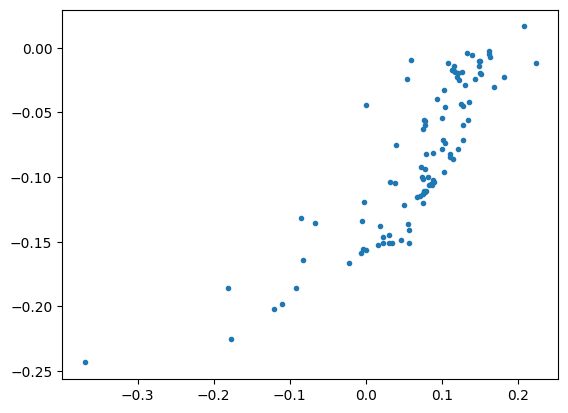

In [ ]:
with torch.no_grad():
    latent_space_samples = torch.randn(100, 2)
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.detach()
    plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

### Training the model

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        # all_samples = torch.cat((real_samples, generated_samples))
        all_samples = torch.cat((real_samples, generated_samples.detach()))

        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        # latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        # generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.2413269281387329
Epoch: 0 Loss G.: 1.8213223218917847
Epoch: 10 Loss D.: 0.6129319667816162
Epoch: 10 Loss G.: 1.0234315395355225
Epoch: 20 Loss D.: 0.6047329902648926
Epoch: 20 Loss G.: 0.9591410756111145
Epoch: 30 Loss D.: 0.6778741478919983
Epoch: 30 Loss G.: 0.6843369603157043
Epoch: 40 Loss D.: 0.6410230994224548
Epoch: 40 Loss G.: 0.9123017191886902
Epoch: 50 Loss D.: 0.6428054571151733
Epoch: 50 Loss G.: 0.7473315596580505
Epoch: 60 Loss D.: 0.6924851536750793
Epoch: 60 Loss G.: 0.6885361075401306
Epoch: 70 Loss D.: 0.6357731223106384
Epoch: 70 Loss G.: 0.9183216691017151
Epoch: 80 Loss D.: 0.697795033454895
Epoch: 80 Loss G.: 0.6912331581115723
Epoch: 90 Loss D.: 0.6188473701477051
Epoch: 90 Loss G.: 0.8821551203727722
Epoch: 100 Loss D.: 0.6475387215614319
Epoch: 100 Loss G.: 0.8415037989616394
Epoch: 110 Loss D.: 0.6323415637016296
Epoch: 110 Loss G.: 0.9518893361091614
Epoch: 120 Loss D.: 0.6384453773498535
Epoch: 120 Loss G.: 0.6794965267181396
Epoch: 13

In [ ]:
latent_space_samples = torch.randn(200, 2)
with torch.no_grad():
    generated_samples = generator(latent_space_samples)


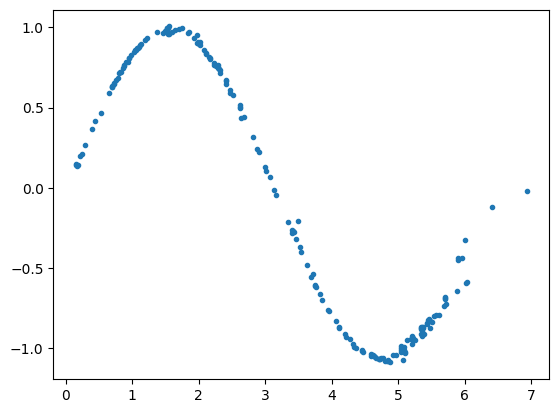

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

## [Loss Modification]

![image.png](attachment:6bfcb059-9570-4895-ada6-8ba40ce20d90.png)
-> 이미지 오류

BCE E(log(1-D(G(z))) --> E[-logD(G(z))]

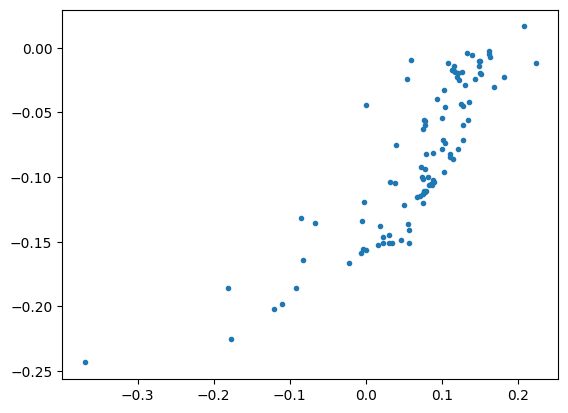

In [ ]:
seed=1111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) # Input
train_data[:, 1] = torch.sin(train_data[:, 0]) # Target

train_labels = torch.zeros(train_data_length)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
discriminator = Discriminator()
generator = Generator()

lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


with torch.no_grad():
    latent_space_samples = torch.randn(100, 2)
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.detach()
    plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        # all_samples = torch.cat((real_samples, generated_samples))
        all_samples = torch.cat((real_samples, generated_samples.detach()))

        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        # latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        # generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = -torch.log(output_discriminator_generated).mean() # BCE E(log(1-D(G(z))) --> E[-logD(G(z))]
        # 중요 시험!


        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.2413269281387329
Epoch: 0 Loss G.: 1.8213223218917847
Epoch: 10 Loss D.: 0.6129319071769714
Epoch: 10 Loss G.: 1.023431420326233
Epoch: 20 Loss D.: 0.5920999050140381
Epoch: 20 Loss G.: 0.981772243976593
Epoch: 30 Loss D.: 0.6400830149650574
Epoch: 30 Loss G.: 0.7527299523353577
Epoch: 40 Loss D.: 0.6437714099884033
Epoch: 40 Loss G.: 0.7688229084014893
Epoch: 50 Loss D.: 0.6464029550552368
Epoch: 50 Loss G.: 0.7422142028808594
Epoch: 60 Loss D.: 0.6322791576385498
Epoch: 60 Loss G.: 0.7873877882957458
Epoch: 70 Loss D.: 0.6093141436576843
Epoch: 70 Loss G.: 0.870589017868042
Epoch: 80 Loss D.: 0.6381603479385376
Epoch: 80 Loss G.: 0.6631253957748413
Epoch: 90 Loss D.: 0.604369044303894
Epoch: 90 Loss G.: 0.9241971969604492
Epoch: 100 Loss D.: 0.6807863116264343
Epoch: 100 Loss G.: 0.9297256469726562
Epoch: 110 Loss D.: 0.6728171110153198
Epoch: 110 Loss G.: 0.823944628238678
Epoch: 120 Loss D.: 0.5829994678497314
Epoch: 120 Loss G.: 0.8903303146362305
Epoch: 130 Lo

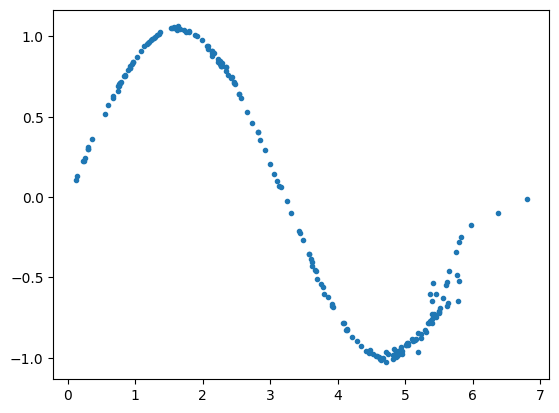

In [ ]:
latent_space_samples = torch.randn(200, 2)
with torch.no_grad():
    generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

## [LSGAN]

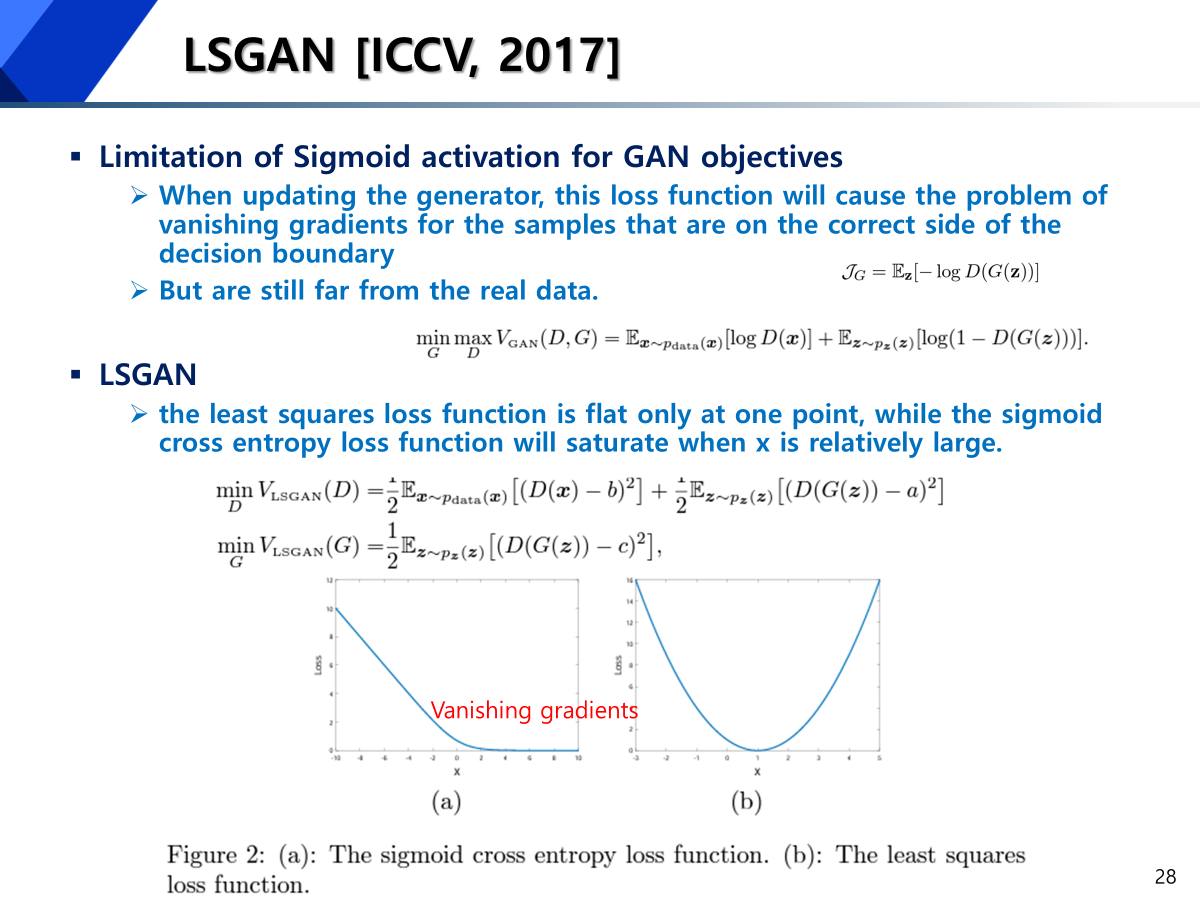

lest square : 가짜 데이터들을 거리를 측정한 뒤, 그 거리를 낮추는 방향으로 학습을 진행하는 것

Least square decision boundary : boundary에서 멀리 떨어져있을 수록 페널티를 주어, 손실함수를 보고 최적화를 진행 -> 이를 통해 결정경계에 가깝게 데이터를 옮김으로써 좀 더 좋은 real한 데이터 분포에 가까워질 수 있는 GAN이 되는 것

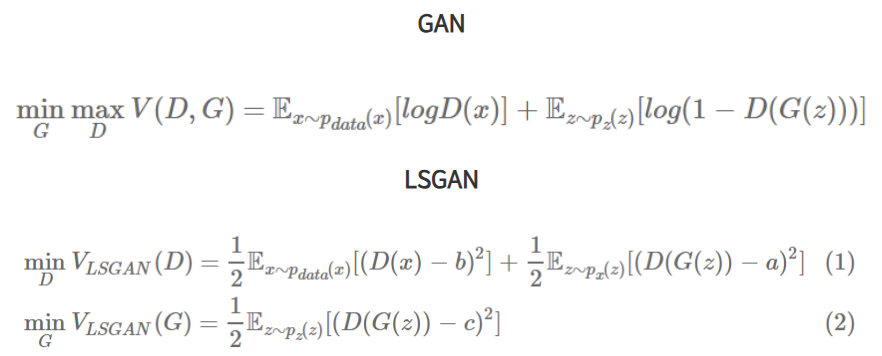

a가 fake label, b가 real label, c가 G 입장에서 D가 진짜라 믿게 하고자하는 fakes를 의미한다.

-> 논문을 보면 f-divergence를 다루기도 하는데, 결론은 LSGAN이 푸는 문제에 작은 조건을 추가하면 LSGAN 방식이 결국 Pearson x^2 divergence를 최소화하는 것과 같은 것이다.

-> 식을 조금 변형해 term을 추가하고, G가 고정일 때와 given일 때의 opticl D의 값을 구하고, D값이 주어졌을 때, Generator의 optimal G 값을 구하면 (b=c=1, b=a=2)라는 조건 하에서 LSGAN이 하는 일이 Pg+Pd와 2Pg 사이의 Pearson X^2 divergence를 최소화하는 것과 같은 말이다
(추가 참고 : https://di-bigdata-study.tistory.com/12)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            # sigmoid 제거 -> LSGAN 이므로
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator()

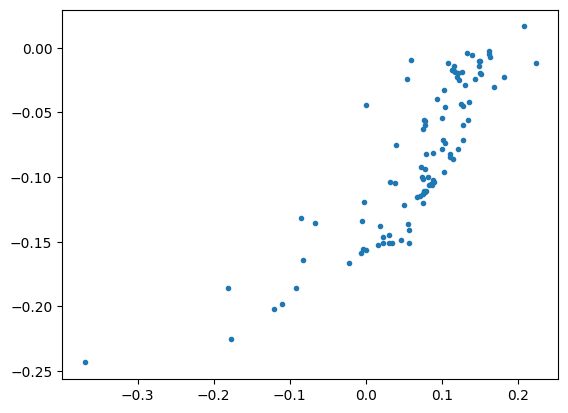

In [ ]:
seed=1111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) # Input
train_data[:, 1] = torch.sin(train_data[:, 0]) # Target

train_labels = torch.zeros(train_data_length)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
discriminator = Discriminator()
generator = Generator()

lr = 0.001
num_epochs = 300

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


with torch.no_grad():
    latent_space_samples = torch.randn(100, 2)
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.detach()
    plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

In [ ]:
def disc_loss(real, fake):
    loss = 0
    # discriminator
    loss += (0.5)*(real-1)**2
    loss += (0.5)*(fake)**2
    return loss.mean()

def gen_loss(fake):
    loss = 0
    loss += (0.5)*(fake-1)**2
    return loss.mean()


In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        # all_samples = torch.cat((real_samples, generated_samples))
        all_samples = torch.cat((real_samples, generated_samples.detach()))

        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        output_real, output_fake = output_discriminator[:output_discriminator.shape[0]//2,:], output_discriminator[output_discriminator.shape[0]//2:,:]
        loss_discriminator = disc_loss(output_real, output_fake)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Training the generator
        generator.zero_grad()
        # generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        # loss_generator = None
        loss_generator = gen_loss(output_discriminator_generated)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.11623090505599976
Epoch: 0 Loss G.: 0.2849995493888855
Epoch: 10 Loss D.: 0.22993214428424835
Epoch: 10 Loss G.: 0.1845490038394928
Epoch: 20 Loss D.: 0.2835536301136017
Epoch: 20 Loss G.: 0.15355609357357025
Epoch: 30 Loss D.: 0.25810757279396057
Epoch: 30 Loss G.: 0.2100566178560257
Epoch: 40 Loss D.: 0.2572663426399231
Epoch: 40 Loss G.: 0.14617392420768738
Epoch: 50 Loss D.: 0.23826375603675842
Epoch: 50 Loss G.: 0.14878138899803162
Epoch: 60 Loss D.: 0.22938251495361328
Epoch: 60 Loss G.: 0.15017741918563843
Epoch: 70 Loss D.: 0.21206434071063995
Epoch: 70 Loss G.: 0.1881382018327713
Epoch: 80 Loss D.: 0.2277790904045105
Epoch: 80 Loss G.: 0.15993386507034302
Epoch: 90 Loss D.: 0.2475670725107193
Epoch: 90 Loss G.: 0.14946094155311584
Epoch: 100 Loss D.: 0.24163636565208435
Epoch: 100 Loss G.: 0.15514567494392395
Epoch: 110 Loss D.: 0.24754281342029572
Epoch: 110 Loss G.: 0.12022753804922104
Epoch: 120 Loss D.: 0.2540914714336395
Epoch: 120 Loss G.: 0.127343326

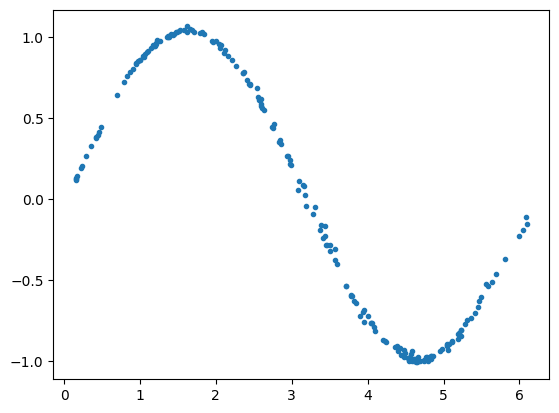

In [ ]:
latent_space_samples = torch.randn(200, 2)
with torch.no_grad():
    generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")